In [14]:
# Install TensorFlow
!pip install tensorflow

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalAveragePooling2D, Dropout, Multiply, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Define paths to your datasets
train_dir = '/content/drive/MyDrive/Retinal fundus images for DR/1.train'
val_dir = '/content/drive/MyDrive/Retinal fundus images for DR/2.val'
test_dir = '/content/drive/MyDrive/Retinal fundus images for DR/3.test'

In [3]:
# Data normalization
datagen = ImageDataGenerator(rescale=1./255)

# Load datasets with class_mode='categorical'
img_height, img_width = 380, 380  # EfficientNet-B4 input size
batch_size = 8

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 638 images belonging to 7 classes.
Found 136 images belonging to 7 classes.
Found 143 images belonging to 7 classes.


In [4]:
# Number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [11]:
# Define the attention mechanism
def attention_module(inputs, ratio=8):
    # Channel-wise attention
    channel_attention = GlobalAveragePooling2D()(inputs)
    channel_attention = Dense(channel_attention.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)(channel_attention)
    channel_attention = Dense(inputs.shape[-1], kernel_initializer='he_normal', use_bias=True)(channel_attention)
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Multiply()([inputs, channel_attention])

    # Spatial attention
    spatial_attention = Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal', use_bias=False)(channel_attention)
    spatial_attention = Multiply()([inputs, spatial_attention])

    return Add()([inputs, spatial_attention])

In [ ]:
# Load the pre-trained EfficientNet-B7 model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Unfreeze some of the later layers in the base model
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers, for example
    layer.trainable = True

In [12]:
# Add custom top layers for your specific task
x = base_model.output
x = attention_module(x)  # Add attention mechanism
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [15]:
# Define the model
model = Model(inputs=base_model.input, outputs=output)

In [16]:
# Compile the model with a lower learning rate
learning_rate = 1e-5
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
# Train the model with early stopping
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,  # Set a higher number of epochs, early stopping will handle it
    callbacks=[early_stopping]
)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 678s 7s/step - accuracy: 0.1760 - loss: 1.9753 - val_accuracy: 0.1176 - val_loss: 2.0738
Epoch 2/15
 1/79 ━━━━━━━━━━━━━━━━━━━━ 23s 295ms/step - accuracy: 0.1250 - loss: 1.8805

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.1250 - loss: 1.8805 - val_accuracy: 0.1176 - val_loss: 2.0737
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 559ms/step - accuracy: 0.3834 - loss: 1.6424 - val_accuracy: 0.1176 - val_loss: 1.9834
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.3750 - loss: 1.7328 - val_accuracy: 0.1176 - val_loss: 1.9822
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 552ms/step - accuracy: 0.5861 - loss: 1.3664 - val_accuracy: 0.1103 - val_loss: 1.9928
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.5000 - loss: 1.2240 - val_accuracy: 0.1103 - val_loss: 1.9923
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 74s 551ms/step - accuracy: 0.5555 - loss: 1.2601 - val_accuracy: 0.1103 - val_loss: 1.9806
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.3750 - loss: 1.2397 - val_accuracy: 0.1029 - val_loss: 1.9809
Epoch 9/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 559ms/step - accuracy: 0.5977 - loss: 1.1379 - val_accuracy: 0.0588 - v

In [18]:
# Evaluate the model
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes  # Use the classes directly

18/18 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step


In [19]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys()))

# Specificity calculation
specificity = np.mean([conf_matrix[i, i] / np.sum(conf_matrix[:, i]) for i in range(num_classes)])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Learning Rate: {learning_rate}")
print("Classification Report:\n", report)

Accuracy: 0.0909
Precision: 0.1957
Recall (Sensitivity): 0.0909
F1 Score: 0.0807
Specificity: nan
Learning Rate: 1e-05
Classification Report:
                          precision    recall  f1-score   support

         1. No DR signs       0.00      0.00      0.00        29
2. Mild (or early) NPDR       1.00      0.19      0.32        26
       3. Moderate NPDR       0.00      0.00      0.00        12
         4. Severe NPDR       0.00      0.00      0.00        27
    5. Very Severe NPDR       0.08      0.29      0.13        17
                 6. PDR       0.04      0.21      0.07        14
        7. Advanced PDR       0.00      0.00      0.00        18

               accuracy                           0.09       143
              macro avg       0.16      0.10      0.07       143
           weighted avg       0.20      0.09      0.08       143



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

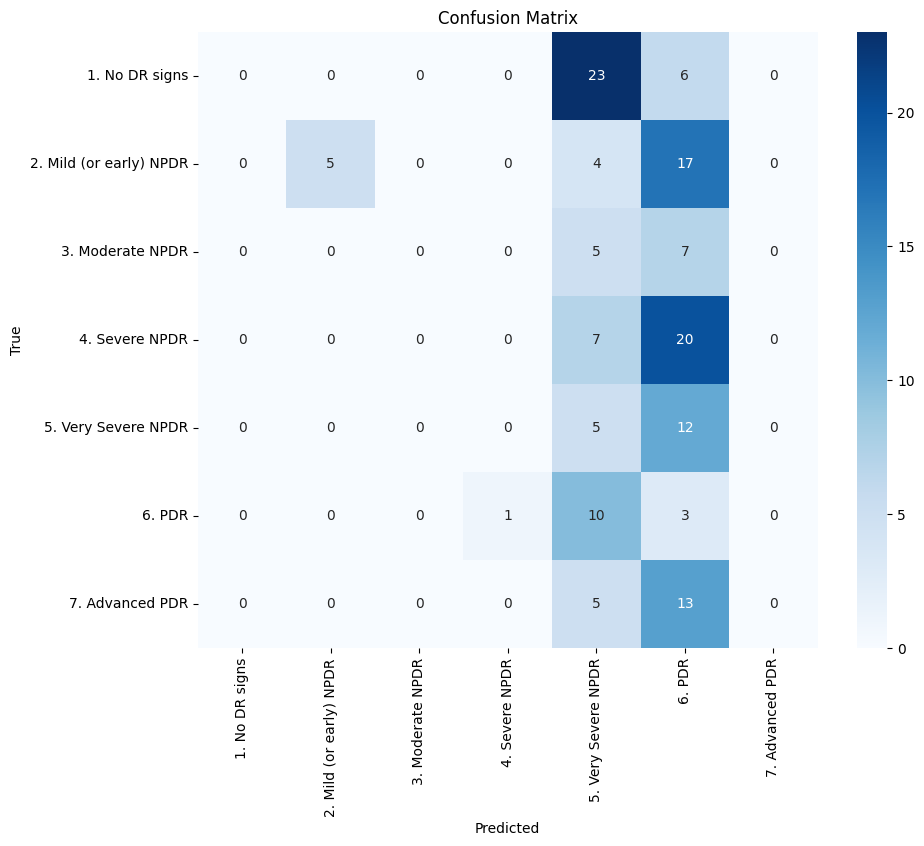

In [20]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()